In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from math import pi, exp
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [68]:
class FirstOrderForward:
    
    # constant parameters used in computing
    _c1 =  1.211243
    _c2 = -0.08972168
    _c3 =  0.001384277
    _c4 = -0.00176566
    _c5 =  0.0001186795
    
    # model parameters
    _pmodel = None
    _vpmodel = None
    _vsmodel = None
    _c11 = None   # = c33 = λ+μ
    _c13 = None   # = λ
    _c44 = None   # = μ
    _vx = None
    _vx = None
    _dt = 0
    _dx = 0
    _dz = 0
    _nt = 0
    _nx = 0
    _nz = 0
    _tmax = 0
    _xmax = 0
    _zmax = 0
    
    def __init__(self, pmodel=None, vpmodel=None, vsmodel=None, tmax=1., xmax=1000., zmax=800., nt=1000, nx=100, nz=80):
        # if not setting model parameter, using a easy model to test

        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)

    # forward modeling operator with precion of O(4,10)
    def o4xFM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        
        # start to compute
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o4xComputeVx(u, v, r, t, h)
                v = self.o4xComputeVz(u, v, r, t, h)
                r = self.o4xComputeTauxx(u ,v, r, t, h)
                t = self.o4xComputeTauzz(u ,v, r, t, h)
                h = self.o4xComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                    else:
                        v[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
      
    # function to oompute the velocity in x axis of the next time step
    def o4xComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._dx * self._pmodel) * convolve(r, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel) * convolve(h, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c11 / (24 * self._pmodel**2 * self._dx**3) * convolve(r, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dz * self._dx**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(t, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(r, kernal, mode='same')  
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(h, kernal, mode='same')
        
        # sum all
        output = u + one + two + three + four + five + six + seven
        
        return output    
    
    # function to oompute the velocity in z axis of the next time step
    def o4xComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt / (self._dx * self._pmodel) * convolve(h, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel) * convolve(t, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c44 / (24 * self._pmodel**2 * self._dx**3) * convolve(h, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dx * self._dz**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(r, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(t, kernal, mode='same')
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = self._dt**3 * self._c11 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(t, kernal, mode='same')
        
        # sum all
        output = v + one + two + three + four + five + six + seven
        
        return output

    # function to oompute the stress on xx
    def o4xComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c11 / self._dx * convolve(u, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c13 / self._dz * convolve(v, kernal, mode='same')
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c11*self._c13 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11* self._c13 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = r + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on zz
    def o4xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c13 / self._dx * convolve(u, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]               
        two= self._dt * self._c11 / self._dz * convolve(v, kernal, mode='same')
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11 * self._c13 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c13**2 + self._c13*self._c44 + self._c11*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13 * self._c11 + self._c13 * self._c44 + self._c11 * self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on xz
    def o4xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c44 / self._dx * convolve(v, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c44 / self._dz * convolve(u, kernal, mode='same')
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dx**3) * convolve(v, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = self._dt**3 * (self._c44**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(u, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[-1 ,1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * self._c44 * (self._c13 + self._c44 + self._c11) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(v, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dz**3) * convolve(u, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    def DrawModel(self):
        if self._nx > self._nz:
            plt.figure(figsize=(20, 4))
        elif self._nx == self._nz:
            plt.figure(figsize=(20, 6))
        else:
            plt.figure(figsize=(20, 8))
        
        ax1 = plt.subplot(1,3,1)
        plt.imshow(self._pmodel.T, cmap=plt.cm.cool)
        plt.title("density model")
        plt.colorbar(shrink=0.8)
        
        plt.subplot(1,3,2)
        plt.imshow(self._vpmodel.T, cmap=plt.cm.cool)
        plt.title("P wave velocity model")
        plt.colorbar(shrink=0.8)

        plt.subplot(1,3,3)
        plt.imshow(self._vsmodel.T, cmap=plt.cm.cool)
        plt.title("S wave velocitydensity model")
        plt.colorbar(shrink=0.8)
        
    def RangeInOne(self, array):
        _max = max(np.max(array), abs(np.min(array)))
        return array / _max        

    def DrawWaveField(self):
        iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawXWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawZWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vz[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24ComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same')
        
        output = u + one + two
        
        return output
        
    def o24ComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same')
        
        output = v + one + two
               
        return output

    def o24ComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same')
        
        output = r + one + two
        
        return output

        
    def o24ComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same')
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same')
        
        output = t + one + two     
            
        return output

    def o24ComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same')
        
        output = h + one + two

        return output

In [69]:
# a test model
xmax = 1500
zmax = 1500
nx = 150
nz = 150
tmax = 0.5
nt = 500
f_m = 30

source_position = [75, 75]
source_direction = 'z'

pmodel = 3000 * np.ones((nx, nz), dtype=float)
vpmodel = 3000 * np.ones((nx, nz), dtype=float)
vsmodel = 1800 * np.ones((nx, nz), dtype=float)

test = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)

# 30Hz ricker wavelet
# f(t)=(1-2*pi^2*f_m^2*t^2)e^(-pi^2*f_m^2*t^2)
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

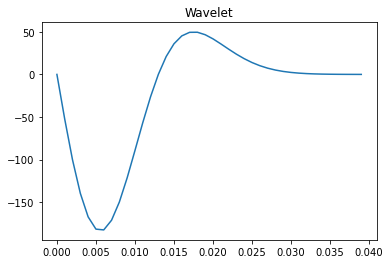

In [70]:
# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

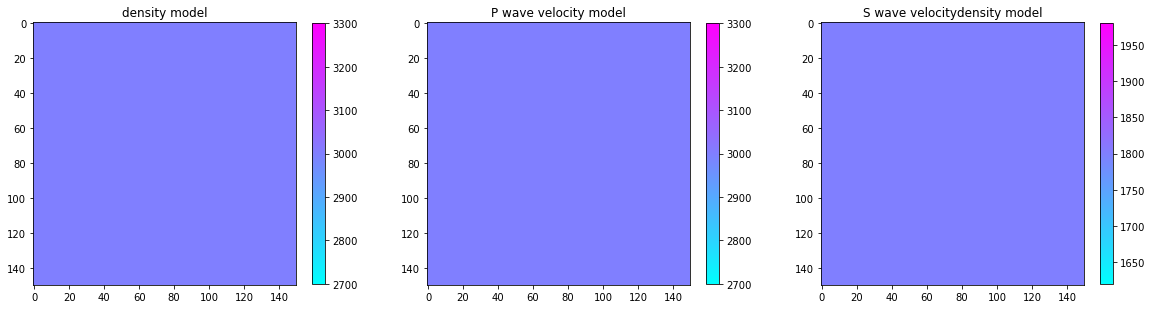

In [71]:
# draw model
test.DrawModel()

In [72]:
test.o24FM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

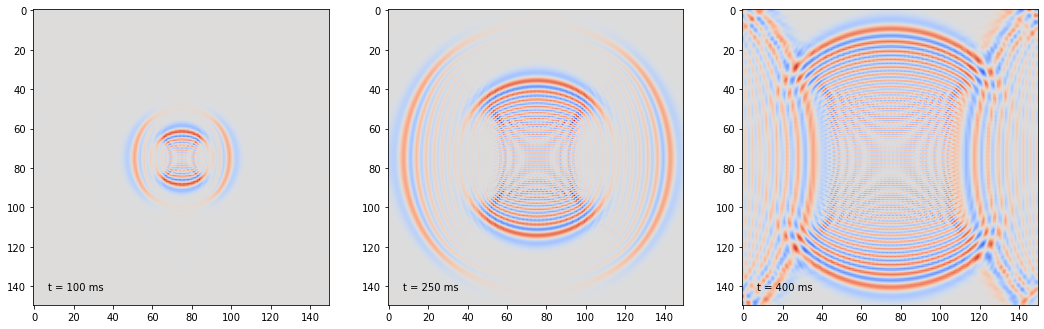

In [73]:
test.DrawXWaveField([100,250, 400])

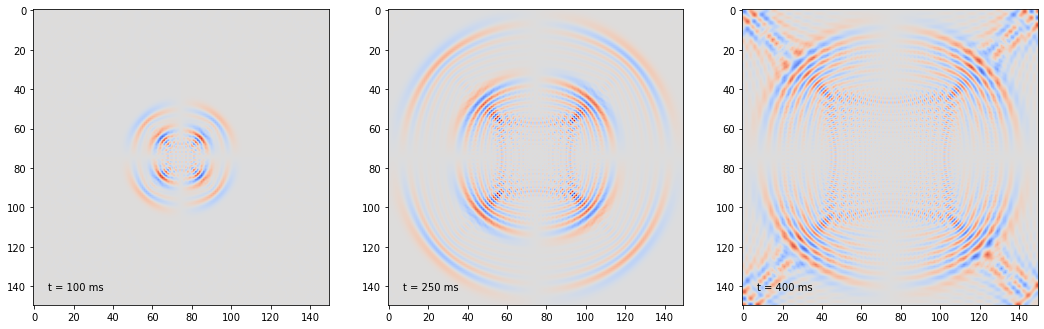

In [74]:
test.DrawZWaveField([100,250, 400])

In [75]:
test_2 = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
test.o4xFM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

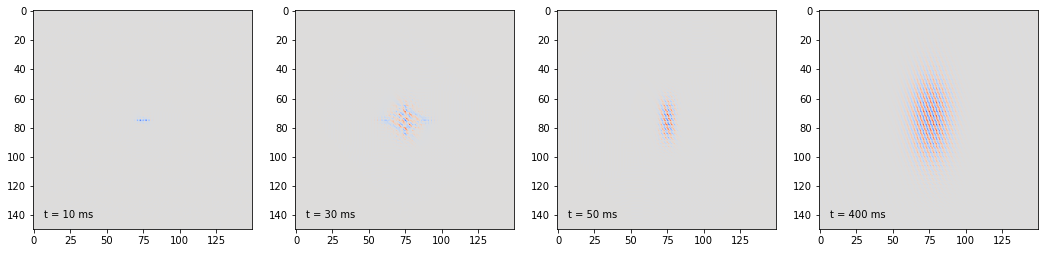

In [79]:
test.DrawXWaveField([10, 30, 50, 400])

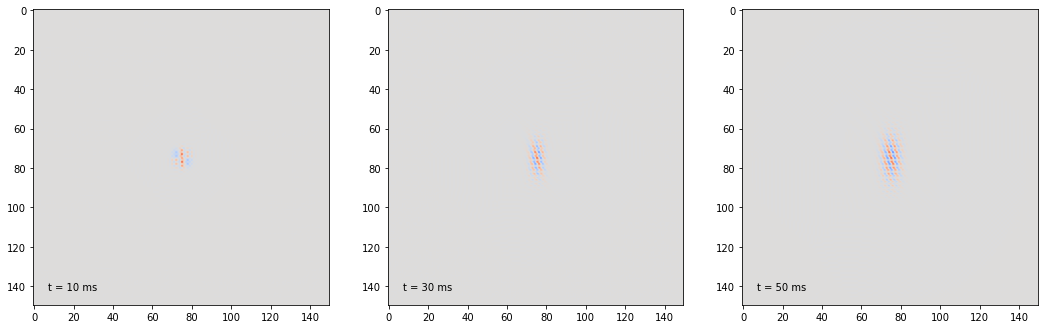

In [77]:
test.DrawZWaveField([10, 30, 50])